In [1]:
from aeon.classification.convolution_based import HydraClassifier, Arsenal, RocketClassifier, MultiRocketHydraClassifier
import numpy as np
import pandas as pd
import glob
import json
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

c:\Users\student\anaconda3\envs\timeseries\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


Functions Defined

In [2]:
# Load and preprocess data
def load_data(directory, start_video_id):
    file_paths = glob.glob(directory + '/*.json')
    dfs = []
    video_id_counter = start_video_id

    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
        df = pd.json_normalize(data)
        df.insert(df.columns.get_loc('image_id'), 'video_id', video_id_counter)
        video_id_counter += 1
        dfs.append(df)

    final_df = pd.concat(dfs, ignore_index=True)
    keypoints_df = final_df['keypoints'].apply(pd.Series)
    col_names = ['keypoints_{}'.format(i+1) for i in range(keypoints_df.shape[1])]
    keypoints_df.columns = col_names
    selected_keypoints = keypoints_df.iloc[:, :51]
    final_df = pd.concat([final_df, selected_keypoints], axis=1)

    return final_df

Loading, assign label and combine video id with keypoints

In [4]:
# Load data for different categories
child_directory = 'C:/Users/student/Desktop/Time Series Analysis/Age_Prediction/P_dataset/Children'
adult_directory = 'C:/Users/student/Desktop/Time Series Analysis/Age_Prediction/P_dataset/Adult'
senior_directory = 'C:/Users/student/Desktop/Time Series Analysis/Age_Prediction/P_dataset/Senior'

child_data = load_data(child_directory, start_video_id=1)
adult_data = load_data(adult_directory, start_video_id=156)
senior_data = load_data(senior_directory, start_video_id=333)

# Assign labels
child_data['label'] = 1
adult_data['label'] = 2
senior_data['label'] = 3

# Combine data
data = pd.concat([child_data, adult_data, senior_data])

# Merge keypoints by video_id
grouped_data = data.groupby('video_id').agg({'keypoints': 'sum', 'label': 'first'}).reset_index()

Convert data format and showing class distribution

In [5]:
# Split features and labels
X = grouped_data['keypoints']
y = grouped_data['label']

# Convert keypoints to numpy arrays and pad sequences to the same length
X = np.array([np.pad(np.array(kp), (0, max(map(len, X)) - len(kp)), 'constant') for kp in X])

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=101)

# Convert the input data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Convert the one-hot encoded y_train to dense array and reshape
y_train_dense = y_train.argmax(axis=1)

# Check the class distribution before oversampling
print(f"Class distribution before oversampling: {Counter(y_train_dense)}")

Class distribution before oversampling: Counter({1: 144, 0: 122, 2: 85})


P Dataset - Age Prediction

Hydra Classifier

Accuracy: 0.5340909090909091


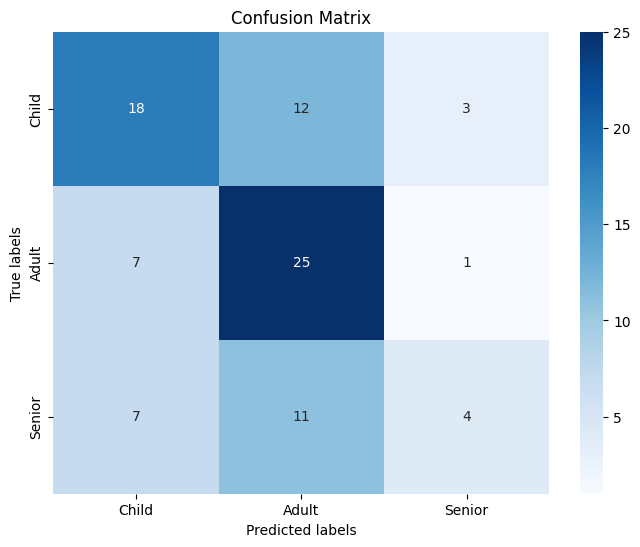

Classification Report:
               precision    recall  f1-score   support

       Child       0.56      0.55      0.55        33
       Adult       0.52      0.76      0.62        33
      Senior       0.50      0.18      0.27        22

    accuracy                           0.53        88
   macro avg       0.53      0.49      0.48        88
weighted avg       0.53      0.53      0.51        88



In [5]:
# Training on Hydra Classifier
classifier =  HydraClassifier(n_kernels=2, n_groups=8, n_jobs=1, random_state=42)
classifier.fit(X_train, y_train_dense)

# Prediction
y_pred = classifier.predict(X_test)

# Evaluate the classifier
y_test_dense = y_test.argmax(axis=1)

# Accuracy Score
accuracy = accuracy_score(y_test_dense, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test_dense, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult', 'Senior'],
            yticklabels=['Child', 'Adult', 'Senior'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_dense, y_pred, target_names=['Child', 'Adult', 'Senior'])
print("Classification Report:\n", class_report)


Rocket Classifier

Accuracy: 0.5681818181818182


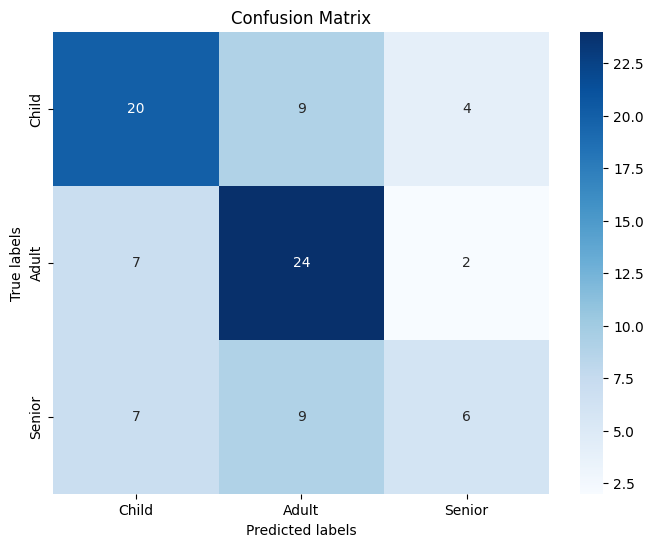

Classification Report:
               precision    recall  f1-score   support

       Child       0.59      0.61      0.60        33
       Adult       0.57      0.73      0.64        33
      Senior       0.50      0.27      0.35        22

    accuracy                           0.57        88
   macro avg       0.55      0.54      0.53        88
weighted avg       0.56      0.57      0.55        88



In [6]:
# Training on Rocket Classifier
classifier =  RocketClassifier(num_kernels=10000, rocket_transform='minirocket', max_dilations_per_kernel=32, 
                               n_features_per_kernel=4, estimator=None, random_state=42, n_jobs=1)
classifier.fit(X_train, y_train_dense)


# Prediction
y_pred = classifier.predict(X_test)

# Evaluate the classifier
y_test_dense = y_test.argmax(axis=1)

# Accuracy Score
accuracy = accuracy_score(y_test_dense, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test_dense, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult', 'Senior'],
            yticklabels=['Child', 'Adult', 'Senior'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_dense, y_pred, target_names=['Child', 'Adult', 'Senior'])
print("Classification Report:\n", class_report)


MultiRocketHydraClassifier

Accuracy: 0.6818181818181818


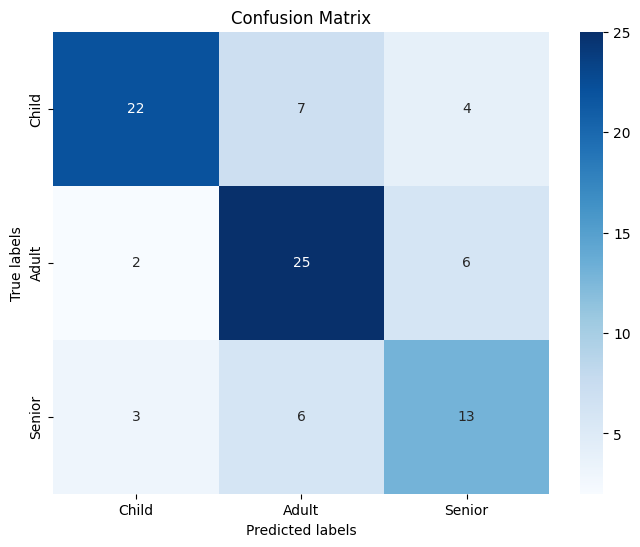

Classification Report:
               precision    recall  f1-score   support

       Child       0.81      0.67      0.73        33
       Adult       0.66      0.76      0.70        33
      Senior       0.57      0.59      0.58        22

    accuracy                           0.68        88
   macro avg       0.68      0.67      0.67        88
weighted avg       0.69      0.68      0.68        88



In [7]:
# Training on MultiRocketHydra Classifier
classifier =  MultiRocketHydraClassifier(n_kernels=2, n_groups=8, n_jobs=1, random_state=42)
classifier.fit(X_train, y_train_dense)


# Prediction
y_pred = classifier.predict(X_test)

# Evaluate the classifier
y_test_dense = y_test.argmax(axis=1)

# Accuracy Score
accuracy = accuracy_score(y_test_dense, y_pred)
print("Accuracy:", accuracy)


cm = confusion_matrix(y_test_dense, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Child', 'Adult', 'Senior'],
            yticklabels=['Child', 'Adult', 'Senior'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_dense, y_pred, target_names=['Child', 'Adult', 'Senior'])
print("Classification Report:\n", class_report)
